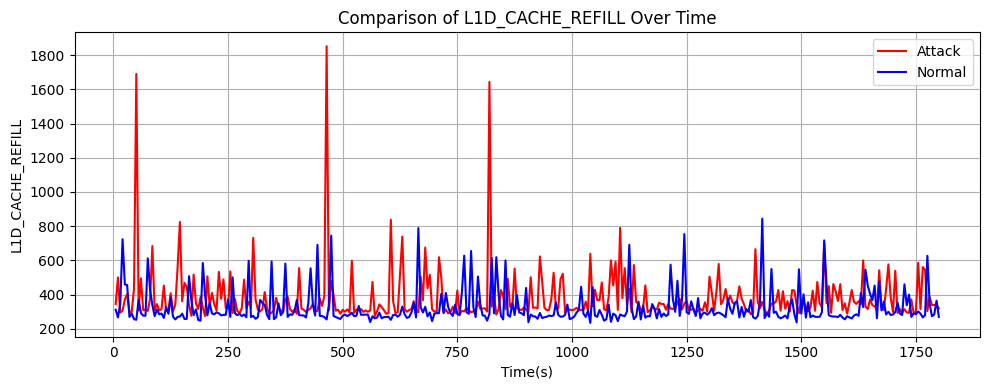

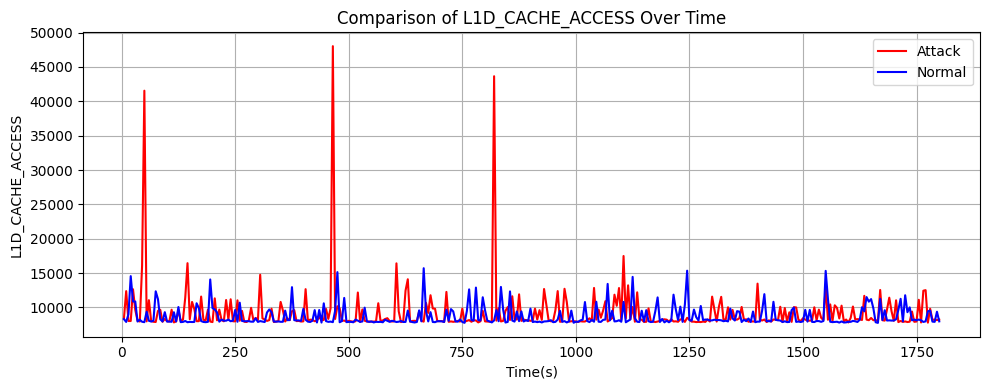

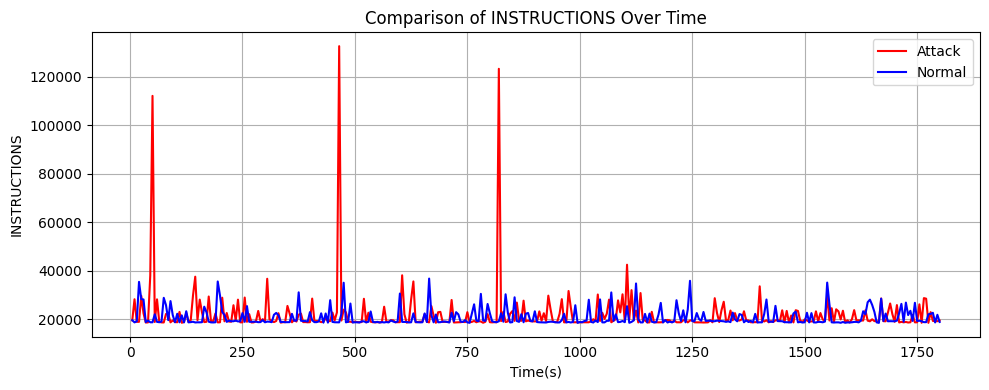

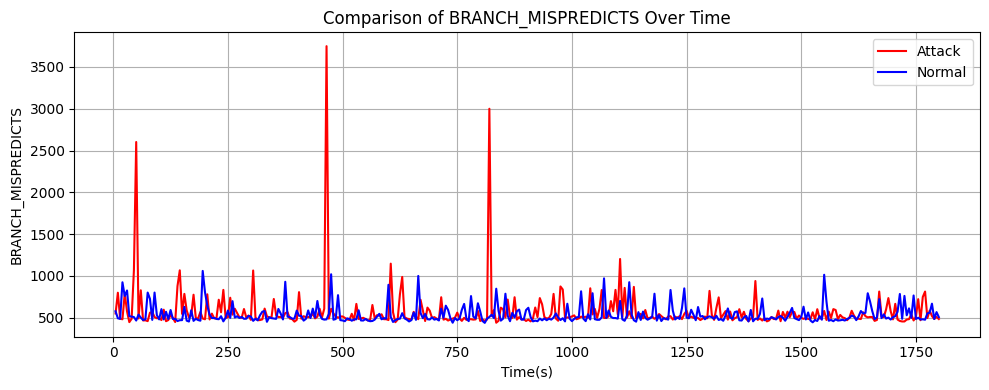

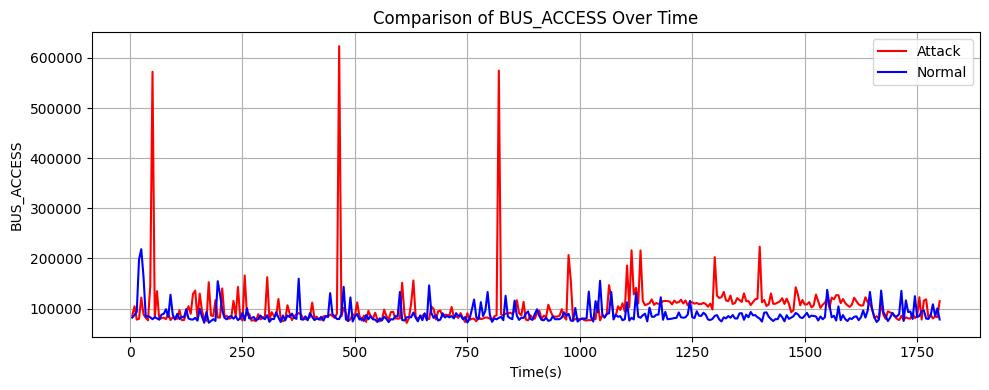

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
file_attack = "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output_attack.csv"
file_normal = "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output0.csv"

# Load the data
df_attack = pd.read_csv(file_attack)
df_normal = pd.read_csv(file_normal)

# Ensure both datasets are aligned on index or time (optional)
min_len = min(len(df_attack), len(df_normal))
df_attack = df_attack.iloc[:min_len]
df_normal = df_normal.iloc[:min_len]

# Features to compare (excluding 'Time(s)')
features = ['L1D_CACHE_REFILL', 'L1D_CACHE_ACCESS', 'INSTRUCTIONS', 'BRANCH_MISPREDICTS', 'BUS_ACCESS']

# Plot each feature
for feature in features:
    plt.figure(figsize=(10, 4))
    plt.plot(df_attack['Time(s)'][:min_len], df_attack[feature], label='Attack', color='red')
    plt.plot(df_normal['Time(s)'][:min_len], df_normal[feature], label='Normal', color='blue')
    plt.xlabel('Time(s)')
    plt.ylabel(feature)
    plt.title(f'Comparison of {feature} Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


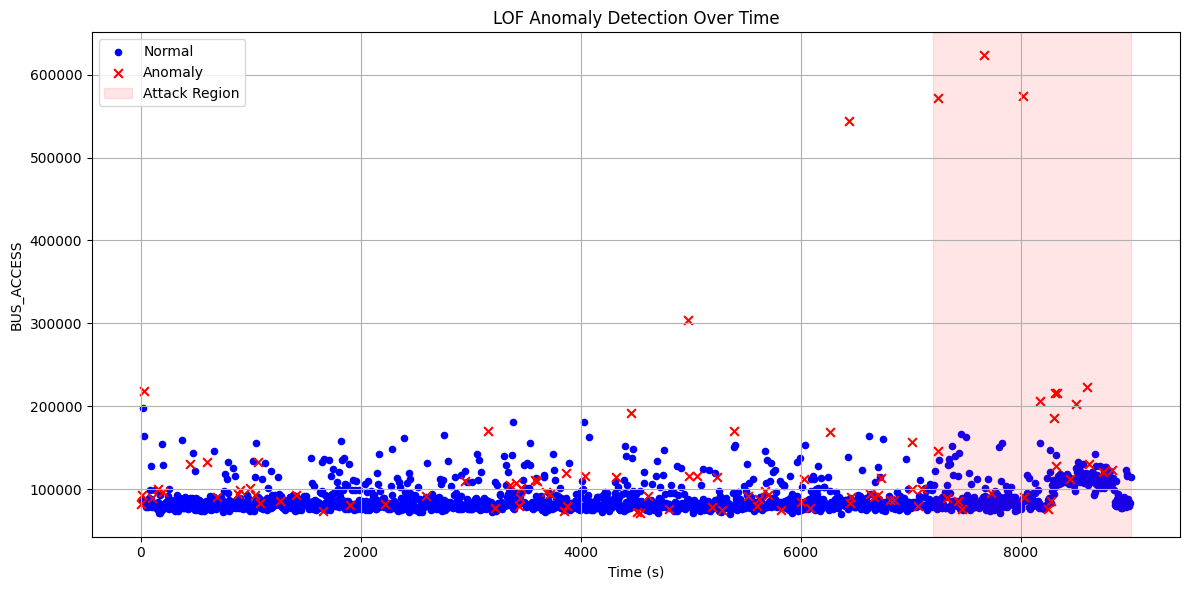

In [6]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# File paths in order: normal chunks first, then attack
file_paths = [
    "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output0.csv",
    "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output1.csv",
    "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output2.csv",
    "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output3.csv",
    "C:/Users/G800613RTS/Desktop/Anomaly/hpc_output_attack.csv"
]

df_list = []

# Each file is 30 minutes long with 5-second intervals → 360 rows
interval_sec = 5
duration_per_file_sec = 30 * 60  # 1800 seconds

for i, path in enumerate(file_paths):
    df = pd.read_csv(path)
    
    # Adjust time based on file index
    time_offset = i * duration_per_file_sec
    df['Time(s)'] = df['Time(s)'] + time_offset

    df_list.append(df)

# Concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

# Select relevant features
features = ['L1D_CACHE_REFILL', 'L1D_CACHE_ACCESS', 'INSTRUCTIONS', 'BRANCH_MISPREDICTS', 'BUS_ACCESS']
X = df[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LOF
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_

# Add results to DataFrame
df['LOF_Prediction'] = y_pred
df['LOF_Score'] = lof_scores

# --------------------------------------
# Plot over time for one feature example
# --------------------------------------

plt.figure(figsize=(12, 6))

plt.scatter(df['Time(s)'][df['LOF_Prediction'] == 1], df['BUS_ACCESS'][df['LOF_Prediction'] == 1], 
            c='blue', label='Normal', s=20)

plt.scatter(df['Time(s)'][df['LOF_Prediction'] == -1], df['BUS_ACCESS'][df['LOF_Prediction'] == -1], 
            c='red', label='Anomaly', s=40, marker='x')
# Add attack window highlight
plt.axvspan(7200, 9000, color='red', alpha=0.1, label='Attack Region')
plt.xlabel('Time (s)')
plt.ylabel('BUS_ACCESS')
plt.title('LOF Anomaly Detection Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


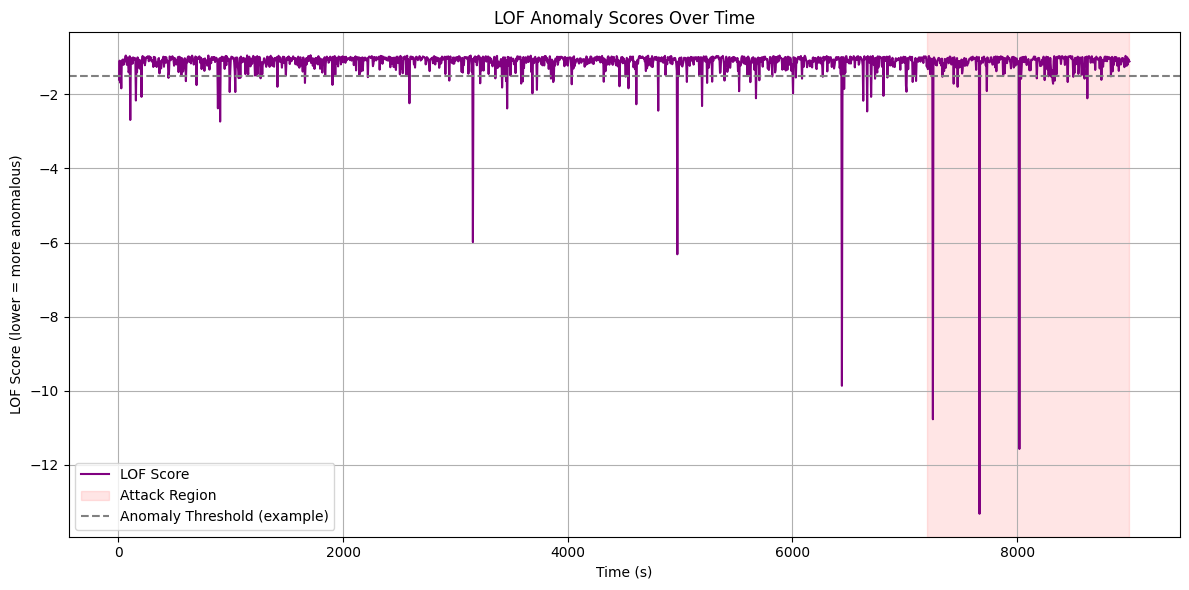

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot LOF scores over time
plt.plot(df['Time(s)'], df['LOF_Score'], color='purple', label='LOF Score')

# Highlight anomaly region
plt.axvspan(7200, 9000, color='red', alpha=0.1, label='Attack Region')

# Draw threshold line (optional, not strict)
plt.axhline(y=-1.5, color='gray', linestyle='--', label='Anomaly Threshold (example)')

# Labels and formatting
plt.xlabel('Time (s)')
plt.ylabel('LOF Score (lower = more anomalous)')
plt.title('LOF Anomaly Scores Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
